In [1]:
import csv
import collections

import pandas
import numpy
import seaborn
import matplotlib.pyplot as plt

%matplotlib inline

## Read entrez gene

In [2]:
# read entrez genes
url = 'https://raw.githubusercontent.com/dhimmel/entrez-gene/5352b31e04ec136e99d25a0ba63e8867aa71b69f/data/genes-human.tsv'
entrez_df = pandas.read_table(url, dtype={'GeneID': str})
human_genes = set(entrez_df.GeneID)
human_coding_genes = set(entrez_df[entrez_df.type_of_gene == 'protein-coding'].GeneID)

## GMT functions

In [3]:
def read_gmt(path):
    read_file = open(path)
    reader = csv.reader(read_file, delimiter='\t')
    for row in reader:
        name = row[0]
        description = row[1]
        genes = set(row[2:])
        yield name, description, genes
    read_file.close()

## Resource downloads

In [4]:
%%capture

# download wikipathways
url = 'http://www.pathvisio.org/data/bots/gmt/wikipathways.gmt'
! wget --timestamping --directory-prefix=download $url

# download MSigDB 5.0 pathways
url = 'https://www.broadinstitute.org/gsea/resources/msigdb/5.0/c2.cp.v5.0.entrez.gmt'
! wget --timestamping --directory-prefix=download $url

## Parse WikiPathways

In [5]:
gmt_generator = read_gmt('download/wikipathways.gmt')
wikipath_df = pandas.DataFrame(gmt_generator, columns = ['name', 'description', 'genes'])
len(wikipath_df)

1302

In [6]:
# Remove genes absent from our entrez gene version
for genes in wikipath_df.genes:
    genes &= human_genes
wikipath_df = wikipath_df[wikipath_df.genes.map(bool)]
len(wikipath_df)

289

In [7]:
wikipath_df.head()

,name,description,genes
152,Tryptophan metabolism(Homo sapiens),http://wikipathways.org/instance/WP465,"set([2639, 316, 51366, 26, 438, 1562, 1576, 89..."
153,Steroid Biosynthesis(Homo sapiens),http://wikipathways.org/instance/WP496,"set([3293, 3292, 2165, 1369, 3294, 3284, 3283,..."
154,Arylamine metabolism(Homo sapiens),http://wikipathways.org/instance/WP694,"set([54600, 1544, 6817, 54657, 6799, 10, 9])"
155,Regulation of Actin Cytoskeleton(Homo sapiens),http://wikipathways.org/instance/WP51,"set([56924, 4659, 2258, 2934, 2260, 22808, 224..."
156,Interleukin-11 Signaling Pathway(Homo sapiens),http://wikipathways.org/instance/WP2332,"set([5595, 3381, 5604, 596, 6714, 7297, 7040, ..."


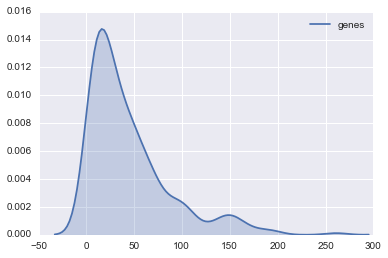

In [8]:
# Density plot of genes per pathway
seaborn.kdeplot(wikipath_df.genes.map(len), shade=True, );

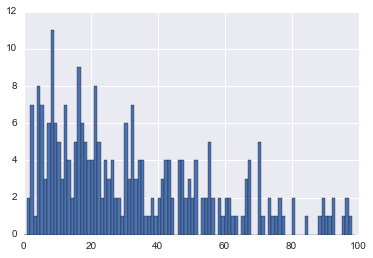

In [9]:
# Histogram of genes per pathway
plt.hist(list(wikipath_df.genes.map(len)), numpy.arange(100));
plt.xlim(0, 100);

## Parse MSigDB Pathways

In [10]:
gmt_generator = read_gmt('download/c2.cp.v5.0.entrez.gmt')
msigdb_df = pandas.DataFrame(gmt_generator, columns = ['name', 'description', 'genes'])
len(msigdb_df)

1330

In [11]:
# Remove genes absent from our entrez gene version
for genes in msigdb_df.genes:
    genes &= human_genes
msigdb_df = msigdb_df[msigdb_df.genes.map(bool)]
len(msigdb_df)

1330

In [12]:
msigdb_df.head()

,name,description,genes
0,KEGG_GLYCOLYSIS_GLUCONEOGENESIS,http://www.broadinstitute.org/gsea/msigdb/card...,"set([3098, 55276, 5214, 229, 5223, 10327, 2538..."
1,KEGG_CITRATE_CYCLE_TCA_CYCLE,http://www.broadinstitute.org/gsea/msigdb/card...,"set([8802, 3417, 1737, 5091, 5161, 4967, 5160,..."
2,KEGG_PENTOSE_PHOSPHATE_PATHWAY,http://www.broadinstitute.org/gsea/msigdb/card...,"set([221823, 729020, 55276, 5214, 229, 7086, 6..."
3,KEGG_PENTOSE_AND_GLUCURONATE_INTERCONVERSIONS,http://www.broadinstitute.org/gsea/msigdb/card...,"set([729020, 7363, 54658, 54577, 79799, 54659,..."
4,KEGG_FRUCTOSE_AND_MANNOSE_METABOLISM,http://www.broadinstitute.org/gsea/msigdb/card...,"set([3098, 29926, 5214, 229, 5208, 3795, 7167,..."


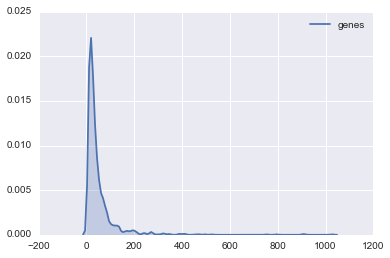

In [13]:
# Density plot of genes per pathway
seaborn.kdeplot(msigdb_df.genes.map(len), shade=True);

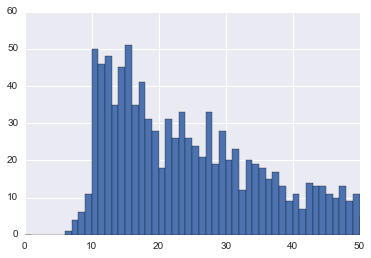

In [14]:
# Histogram of genes per pathway
plt.hist(msigdb_df.genes.map(len), numpy.arange(100));
plt.xlim(0, 50);

In [15]:
# MSigDB pathways per source database
# https://www.broadinstitute.org/gsea/msigdb/collection_details.jsp#CP
collections.Counter(msigdb_df.name.map(lambda x: x.split('_', 1)[0]))

Counter({'BIOCARTA': 217,
         'KEGG': 186,
         'NABA': 10,
         'PID': 196,
         'REACTOME': 674,
         'SA': 10,
         'SIG': 8,
         'ST': 28,
         'WNT': 1})

## Merge resources into a pathway dataframe

In [16]:
pathway_df = pandas.concat([
    pandas.DataFrame({
        'identifier': wikipath_df['description'].map(lambda x: x.rsplit('/', 1)[1]),
        'name': wikipath_df['name'],
        'url': wikipath_df['description'],
        'source': 'wikipathways',
        'license': 'CC-BY 3.0',
        'genes': wikipath_df.genes
    }),
    pandas.DataFrame({
        'identifier': msigdb_df['name'],
        'name': msigdb_df['name'],
        'url': msigdb_df['description'],
        'source': 'msigdb',
        'license': 'http://www.broadinstitute.org/cancer/software/gsea/wiki/index.php/License_info',
        'genes': msigdb_df.genes}),
])[['identifier', 'name', 'url', 'source', 'license', 'genes']]
len(pathway_df)

1619

In [17]:
# Remove duplicate pathways
pathway_df.genes = pathway_df.genes.map(frozenset)
pathway_df = pathway_df.drop_duplicates(['genes'])
len(pathway_df)

1617

In [18]:
pathway_df['coding_genes'] = pathway_df.genes.map(lambda x: x & human_coding_genes)

In [19]:
pathway_df.insert(3, 'n_genes', pathway_df.genes.map(len))
pathway_df.insert(4, 'n_coding_genes', pathway_df.coding_genes.map(len)) 

In [20]:
pathway_df.head()

,identifier,name,url,n_genes,n_coding_genes,source,license,genes,coding_genes
152,WP465,Tryptophan metabolism(Homo sapiens),http://wikipathways.org/instance/WP465,46,46,wikipathways,CC-BY 3.0,"(2639, 316, 51366, 26, 438, 1562, 1576, 8942, ...","(2639, 316, 51366, 26, 1562, 438, 1576, 8942, ..."
153,WP496,Steroid Biosynthesis(Homo sapiens),http://wikipathways.org/instance/WP496,10,10,wikipathways,CC-BY 3.0,"(3293, 3292, 2165, 1369, 3294, 3284, 3283, 514...","(3293, 3292, 2165, 3294, 1369, 3284, 3283, 514..."
154,WP694,Arylamine metabolism(Homo sapiens),http://wikipathways.org/instance/WP694,7,7,wikipathways,CC-BY 3.0,"(54600, 54657, 6799, 10, 1544, 6817, 9)","(54600, 1544, 6817, 54657, 6799, 10, 9)"
155,WP51,Regulation of Actin Cytoskeleton(Homo sapiens),http://wikipathways.org/instance/WP51,148,148,wikipathways,CC-BY 3.0,"(56924, 4659, 2258, 2934, 2260, 22808, 2245, 2...","(56924, 4659, 2258, 2934, 2260, 22808, 2245, 2..."
156,WP2332,Interleukin-11 Signaling Pathway(Homo sapiens),http://wikipathways.org/instance/WP2332,44,44,wikipathways,CC-BY 3.0,"(5595, 3381, 5604, 596, 6714, 7297, 7040, 5781...","(5595, 3381, 5604, 596, 6714, 7297, 7040, 5781..."


In [21]:
# Create a dataframe for writing as a tsv. Multi-element fields are pipe delimited.
write_df = pathway_df.copy()
join = lambda x: '|'.join(map(str, x))
for column in 'genes', 'coding_genes':
    write_df[column] = write_df[column].map(join)

write_df.to_csv('data/pathways.tsv', index=False, sep='\t')